In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import zipfile

In [3]:
data = pd.read_csv("nlp-train.csv")
print(data.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [4]:
# Feature Imformation 
data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [5]:
# Data Dimension 

data.shape 

(159571, 8)

In [6]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [7]:
# Check Missing Value 

print(data["comment_text"].isna().sum())

# dropna 

0


In [8]:
# check missing values in numeric columns
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
unlabelled_in_all = data[(data['toxic']!=1) & (data['severe_toxic']!=1) &
                             (data['obscene']!=1) & (data['threat']!=1) &
                             (data['insult']!=1) & (data['identity_hate']!=1)]
print('Percentage of unlabelled comments or good comments is ', len(unlabelled_in_all)/len(data)*100)

Percentage of unlabelled comments or good comments is  89.83211235124176


In [10]:
labelled_in_all = data[(data['toxic']==1) & (data['severe_toxic']==1) &
                             (data['obscene']==1) & (data['threat']==1) &
                             (data['insult']==1) & (data['identity_hate']==1)]
print('Percentage of comments which is present in all categories is ', len(labelled_in_all)/len(data)*100)

Percentage of comments which is present in all categories is  0.019427088882065038


In [11]:
# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in train is {}'.format(len(data)))
print(data[cols_target].sum())

Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


In [12]:
#Examining correlation

<AxesSubplot:title={'center':'Correlation of features & targets'}>

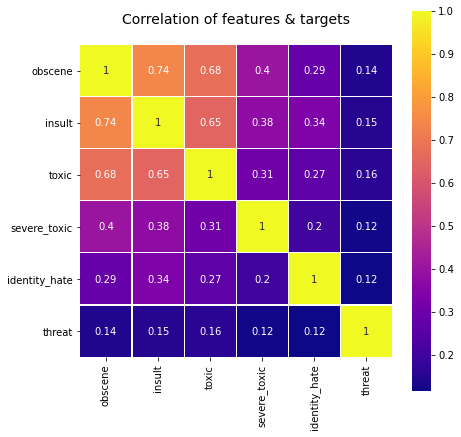

In [13]:
target_data = data[cols_target]
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(target_data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

In [14]:
#Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

Now this kind of problem is
1) Multi class problem and not Binary

2) Also all classes are not independent but rather dependent or correlated

3) A comment can belong to multiple classes at the same time for e.g. comment can be toxic and insulting at the same time

Let us simplify the problem by first classifying the comments as "block" vs "allow"

In [15]:
data['block'] =data[cols_target].sum(axis =1)
print(data['block'].value_counts())
data['block'] = data['block'] > 0 
data['block'] = data['block'].astype(int)
print(data['block'].value_counts())

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: block, dtype: int64
0    143346
1     16225
Name: block, dtype: int64


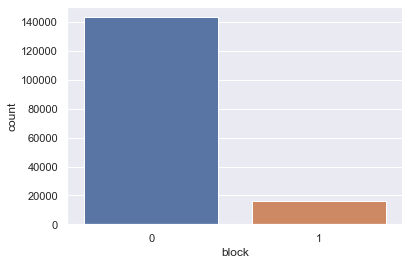

In [16]:
# look at the count plot for text length
sns.set()
sns.countplot(x="block" , data = data )
plt.show()

In [17]:
# Event Rate 

print("Percentage Event Rate : " , round(100*data['block'].sum()/data.shape[0],2) , "%")

Percentage Event Rate :  10.17 %


In [18]:
# Let's look at the character length for the rows in the training data and record these
data['char_length'] = data['comment_text'].apply(lambda x: len(str(x)))

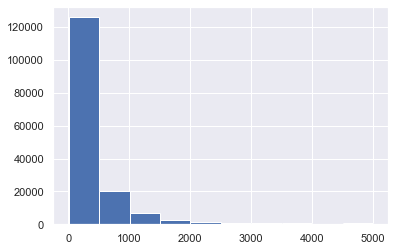

In [19]:
# look at the histogram plot for text length
sns.set()
data['char_length'].hist()
plt.show()

In [20]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [21]:
%%time 
# clean the comment_text in train_df [Thanks to Pulkit Jha for the useful pointer.]
data['comment_text'] = data['comment_text'].map(lambda com : clean_text(com))

Wall time: 6.18 s


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['comment_text'], data['block'], test_size=0.2, random_state=42)

In [23]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(127656,) (31915,)
(127656,) (31915,)


In [24]:
X_train

140030    grandma terri should burn in trash grandma ter...
159124    9 may 2009 utc it would be easiest if you were...
60006     the objectivity of this discussion is doubtful...
65432                          shelly shock shelly shock is
154979    i do not care refer to ong teng cheong talk pa...
                                ...                        
119879    redirect talk john loveday experimental physicist
103694     back it up post the line here with the reference
131932    i wo not stop that sometimes germanic equals g...
146867    british bands i think you have mistaken scotti...
121958    you are wrong justin thompson is mentioned in ...
Name: comment_text, Length: 127656, dtype: object

In [25]:
 X_test

119105    geez are you forgetful we have already discuss...
131631    carioca rfa thanks for your support on my requ...
125326    birthday no worries it what i do enjoy ur day ...
111256    pseudoscience category i am assuming that this...
83590     and if such phrase exists it would be provided...
                                ...                        
121162    would you claim them to be part of the ignoran...
34019     the lyrics is found in the german version so i...
83938     encyclopedia titanica references do not source...
78687             a silly fat cow who wo not leave me alone
127984    shazbot now your lieing you already stated you...
Name: comment_text, Length: 31915, dtype: object

In [26]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features = 10000, stop_words='english')
#vect = TfidfVectorizer(stop_words='english')
print(vect)

TfidfVectorizer(max_features=10000, stop_words='english')


In [27]:
%%time 
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)
# examine the document-term matrix created from X_train
X_train_dtm

Wall time: 5.01 s


<127656x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2792162 stored elements in Compressed Sparse Row format>

In [28]:
X_train_dtm.shape

(127656, 10000)

In [29]:
100*2792162/ (127656*10000)

0.2187254809801341

In [30]:
%%time
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
X_test_dtm = vect.transform(X_test)
# examine the document-term matrix from X_test
X_test_dtm

Wall time: 1.16 s


<31915x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 688258 stored elements in Compressed Sparse Row format>

In [31]:
X_test_dtm.shape

(31915, 10000)

In [32]:
#Using Logistic Regression:

# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
logreg = LogisticRegression(C=1, max_iter = 2000)



# train the model using X_train_dtm & y_train
logreg.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = logreg.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = logreg.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))

Training accuracy is 0.9594613649182178
Test accuracy is 0.9563214789284036
[[28507   164]
 [ 1230  2014]]


In [33]:
output=logreg.predict(vect.transform(np.array([input('Sample Input text: ')])))
output=str(output)
if (output=="[1]"):
  print('Toxic')
elif (output=="[0]"):
  print('Not Toxic')

Not Toxic


In [34]:

(28507 + 2014)/(28507+2014+164+1230)

0.9563214789284036

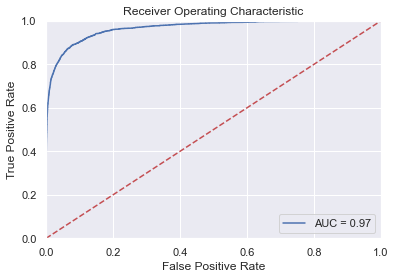

In [35]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test_dtm)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [36]:
from sklearn.metrics import f1_score


print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

F1 score on Test data :  0.7428992991516045


In case of Class Imbalance - we use F1 score as a general measure for the model performance
Depending on the Business case - we need to fine tune the model

There is a Precision vs Recall Trade off

If you want to capture all toxic tweets - then some of the good tweets will be misclassified as bad tweets

In [37]:
y_pred_test = logreg.predict_proba(X_test_dtm)[:,1]
#print(y_pred_test)
y_pred_test = y_pred_test >= 0.2 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Test accuracy is 0.9515588281372396
[[27777   894]
 [  652  2592]]
F1 score on Test data :  0.7702823179791977


In [38]:
#Using Decision Trees
%%time 

from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier 

dt_clf = DecisionTreeClassifier()
# train the model using X_train_dtm & y_train
dt_clf.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = dt_clf.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = dt_clf.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

UsageError: Line magic function `%%time` not found.


Using Ensemble of trees

In [39]:
%%time 
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 

rf_clf = RandomForestClassifier()

# train the model using X_train_dtm & y_train
rf_clf.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = rf_clf.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = rf_clf.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Training accuracy is 0.9987544651250235
Test accuracy is 0.9573554754817484
[[28295   376]
 [  985  2259]]
F1 score on Test data :  0.7684980438850144
Wall time: 4min 32s


In [40]:
# Fine Tuning Random Forest 

y_pred_test = rf_clf.predict_proba(X_test_dtm)[:,1]
y_pred_test = y_pred_test >= 0.05 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Test accuracy is 0.8118752937490208
[[22853  5818]
 [  186  3058]]
F1 score on Test data :  0.5046204620462046


In [41]:
%%time
from sklearn.metrics import f1_score
from sklearn.linear_model  import PassiveAggressiveClassifier 

pa_clf = PassiveAggressiveClassifier()

# train the model using X_train_dtm & y_train
pa_clf.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = pa_clf.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = pa_clf.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Training accuracy is 0.9755984834242025
Test accuracy is 0.9530314898950337
[[28144   527]
 [  972  2272]]
F1 score on Test data :  0.7519443984775774
Wall time: 607 ms


In [42]:
%%time 
from sklearn.metrics import f1_score
import xgboost 

xgb = xgboost.XGBClassifier()
# train the model using X_train_dtm & y_train
xgb.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = xgb.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = xgb.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))


C:\Users\shakt\anaconda3\envs\vggfacemodel\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:49:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy is 0.9605032274237012
Test accuracy is 0.9544414851950493
[[28513   158]
 [ 1296  1948]]
F1 score on Test data :  0.7282242990654205
Wall time: 18.3 s


In [43]:
# Fine Tuning XGBOOST

y_pred_test = xgb.predict_proba(X_test_dtm)[:,1]
y_pred_test = y_pred_test >= 0.06 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Test accuracy is 0.8847877173742754
[[25405  3266]
 [  411  2833]]
F1 score on Test data :  0.6064433265546398


In [44]:
import lightgbm 

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

train_data = lightgbm.Dataset(X_train_dtm, label=y_train)
test_data = lightgbm.Dataset(X_test_dtm, label=y_test)

clf = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=500,
                       early_stopping_rounds=10)

C:\Users\shakt\anaconda3\envs\vggfacemodel\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.346368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.799381
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.842415
[3]	valid_0's auc: 0.866246
[4]	valid_0's auc: 0.872495
[5]	valid_0's auc: 0.884018
[6]	valid_0's auc: 0.887705
[7]	valid_0's auc: 0.888553
[8]	valid_0's auc: 0.893005
[9]	valid_0's auc: 0.892921
[10]	valid_0's auc: 0.894356
[11]	valid_0's auc: 0.895582
[12]	valid_0's auc: 0.895666
[13]	valid_0's auc: 0.895692
[14]	valid_0's auc: 0.896003
[15]	valid_0's auc: 0.896534
[16]	v

In [45]:
# Fine Tuning LIGHT GBM

y_pred_test = clf.predict(X_test_dtm)
y_pred_test = y_pred_test >= 0.35 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Test accuracy is 0.899138336205546
[[25799  2872]
 [  347  2897]]
F1 score on Test data :  0.642849217796516


In [46]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [47]:
import eli5

eli5.show_weights(logreg,vec = vect, top = 15)  # logistic regression
# will give you top 15 features or words  which makes a comment toxic 

Weight?,Feature
+16.643,fuck
+13.475,fucking
+12.117,shit
+11.670,idiot
+11.024,stupid
+10.370,ass
+9.229,asshole
+8.903,bullshit
+8.776,suck
+8.692,bitch


In [48]:
eli5.show_weights(xgb,vec = vect,top = 15)  # XGBoost
# will give you top 15 features or words  which makes a comment toxic 

TypeError: 'NoneType' object is not iterable

In [ ]:
X_test.iloc[718]

'by the way the exchange between rjensen is jpgordon is a sock puppet conversation pathetic really 129 133 127 244'

In [ ]:
eli5.show_prediction(logreg, vec = vect, doc =  X_test.iloc[718]) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
